In [15]:
import sys
import os

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Parent directory
sys.path.append(base_path)
file_path = os.path.join(base_path, "data/boston/bike_trip_focused_data.parquet")


In [16]:
import os
import numpy as np
import pickle as pkl 
import time
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import shuffle
import shap
import DIFFI.interpretability_module as interp
from DIFFI.utils import *

from src import data_processing as dp
from datetime import datetime


In [17]:
station_data = dp.from_trip_to_station_focused(file_path)

In [18]:
features = [
    'count',                 # Core usage metric
    'distance_mean',         # Average trip distance
    'tripduration_mean',     # Average trip duration
    'speed_mean',            # Average trip speed
    'temp_mean',             # Weather impact
    'prcp_mean',             # Weather impact
    'wspd_mean',             # Weather impact
    'hour',                  # Temporal variation
    'dayofweek',             # Temporal variation
    'nearby_transit_stops'   # Station context
]
X = station_data[features].fillna(0)


In [19]:
iforest = IsolationForest(n_estimators= 500, max_samples=1024, contamination='auto', random_state=0)
iforest.fit(X)
y_pred = np.array(iforest.decision_function(X) < 0).astype('int')


In [20]:
sorted_idx = diffi_ranks(X, n_trees=100, max_samples=1024, n_iter=5)
sorted_feature_names = X.columns[sorted_idx].tolist()

In [21]:
# Local-DIFFI
diffi_te, ord_idx_diffi_te, exec_time_diffi_te = local_diffi_batch(iforest, X.iloc[y_pred == 1][:100])
print('Average computational time Local-DIFFI: {}'.format(round(np.mean(exec_time_diffi_te),3)))

Average computational time Local-DIFFI: 0.243


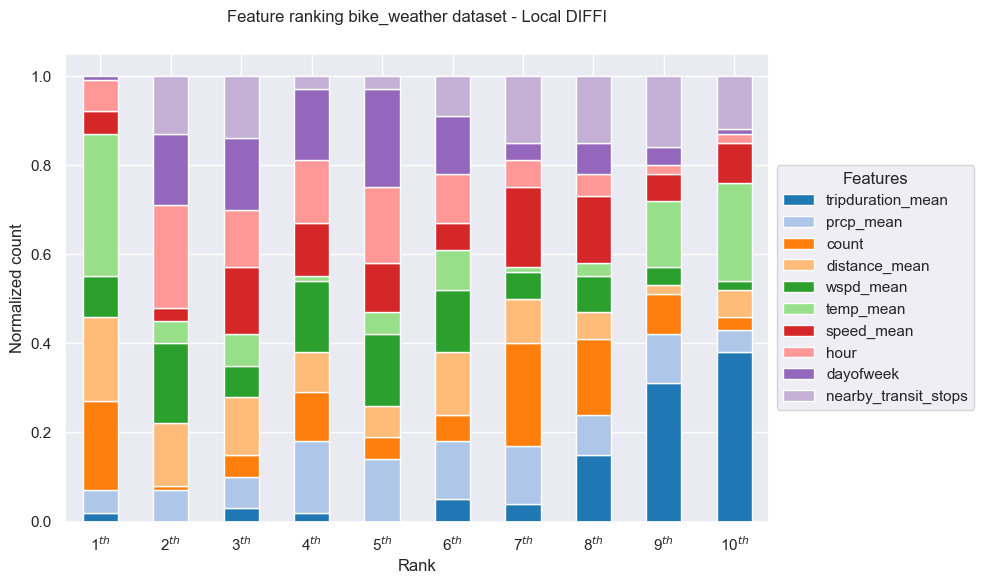

In [22]:
plot_feature_ranking(ord_idx_diffi_te, title = 'Feature ranking bike_weather dataset - Local DIFFI', sorted_feature_names = sorted_feature_names)